In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.models import Model

from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from google.colab import drive
from sklearn.utils.class_weight import compute_class_weight
from getpass import getpass

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_directory = '/content/drive/My Drive/Miniproject/chest_xray/'

In [5]:
train_dir = '/content/drive/My Drive/Miniproject/chest_xray/train'
test_dir = '/content/drive/My Drive/Miniproject/chest_xray/test'
val_dir = '/content/drive/My Drive/Miniproject/chest_xray/val'

In [6]:
train_normal_dir = os.path.join(data_directory, 'train', 'NORMAL')
train_pneumonia_dir = os.path.join(data_directory, 'train', 'PNEUMONIA')
test_normal_dir = os.path.join(data_directory, 'test', 'NORMAL')
test_pneumonia_dir = os.path.join(data_directory, 'test', 'PNEUMONIA')

In [7]:

pneumonia = os.listdir('/content/drive/My Drive/Miniproject/chest_xray/train/PNEUMONIA')
normal = os.listdir('/content/drive/My Drive/Miniproject/chest_xray/train/NORMAL')

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust the target size based on your model requirements
    batch_size=32,
    class_mode='binary',     # 'binary' for binary classification
)

Found 5216 images belonging to 2 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

Found 624 images belonging to 2 classes.


In [11]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

Found 16 images belonging to 2 classes.


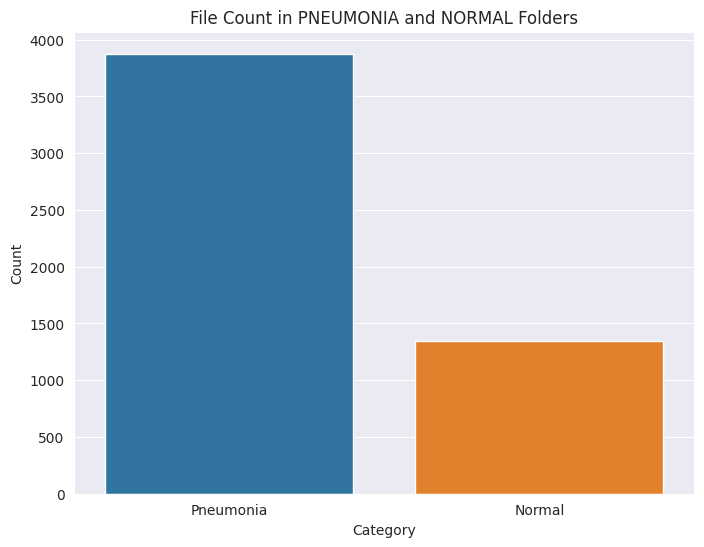

In [12]:
l = []
pneumonia_count = len(pneumonia)
normal_count = len(normal)
data = {'Category': ['Pneumonia', 'Normal'], 'Count': [pneumonia_count, normal_count]}
df = pd.DataFrame(data)

sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Category', y='Count')
plt.title('File Count in PNEUMONIA and NORMAL Folders')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [13]:
y = train_generator.classes

# Now 'y' contains the numerical labels for your dataset
print(y)
unique_classes = np.unique(y)

# Calculate class weights for 'NORMAL' and 'PNEUMONIA' classes
class_weights= compute_class_weight('balanced', classes=unique_classes, y=y)
print(class_weights)

[0 0 0 ... 1 1 1]
[1.9448173  0.67303226]


In [14]:
class_weight = {0: 1.9448173, 1: 0.67303226}

In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
for layer in base_model.layers:
    layer.trainable = False

# Add a new fully connected layer for pneumonia classification
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(
    train_generator,
    epochs=3,  # Adjust the number of epochs based on your needs
    validation_data=val_generator,
    class_weight=class_weight
)

Epoch 1/3
163/163 [==============================] - 3592s 22s/step - loss: 0.3524 - accuracy: 0.9016 - val_loss: 1.1974 - val_accuracy: 0.6875
Epoch 2/3
163/163 [==============================] - 3521s 22s/step - loss: 0.1533 - accuracy: 0.9431 - val_loss: 0.3164 - val_accuracy: 0.8750
Epoch 3/3
163/163 [==============================] - 3559s 22s/step - loss: 0.1368 - accuracy: 0.9498 - val_loss: 0.5095 - val_accuracy: 0.6875


20/20 [==============================] - 414s 21s/step


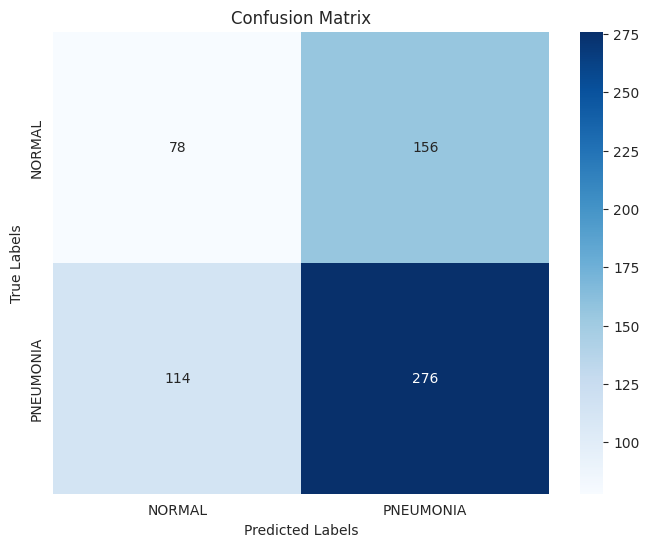

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels and predicted labels
true_labels = test_generator.classes  # Replace with your actual true labels
predicted_probabilities = model.predict(test_generator)
predicted_labels = (predicted_probabilities > 0.5).astype(int)  # Assuming binary classification
  # Replace with your model's predicted labels

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
model.save("xray_model11.keras")
model.save('/content/drive/My Drive/Miniproject/xray_model11.keras')